In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.fft import rfft, rfftfreq, irfft
from scipy.stats import skew
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.ticker as mticker
import matplotlib
# import scienceplots
# plt.style.use(["science","no-latex","light"])

def inverse_logit_transform(data, order=1):
    out = 1 + 1 / np.exp(data)
    out = np.power(out, -1 / order)
    return out

def make_rfft(data, sample_rate=500.5005):
    yf = rfft(data)
    xf = rfftfreq(len(data), 1 / sample_rate)
    return xf, np.abs(yf)

def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

/home/wcx/multiresolution_forecasting/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Performance Comparison

calculate time and freq RMSE

In [18]:
# dataset = "solete"
dataset = "mfred"
# dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

all_freq_results, all_time_results = [], []
detail_time_results, detail_freq_results = [], []
# loop for seeds
for i in range(20):
# for i in range(len(proposed_preds)):
    proposed_model = {"Proposed": proposed_preds[i]}
    all_preds = {
        **proposed_model,
        **bench_raw_preds[i],
        **bench_bu_preds[i],
        **bench_opt_preds[i]
    }
    freq_result = {name: {} for name in sorted(all_preds.keys())}
    time_result = {name: {} for name in sorted(all_preds.keys())}
    d_freq_result = {name: {} for name in sorted(all_preds.keys())}
    d_time_result = {name: {} for name in sorted(all_preds.keys())}

    # loop for models
    for name in sorted(all_preds.keys()):
        all_term_preds = all_preds[name]
        # loop for avg terms
        for avg_terms in sorted(all_term_preds.keys()):
            preds, labels = all_term_preds[avg_terms]
            error_freq = []

            # # mfred
            # if dataset == "mfred":
            #     preds = preds[23:23+7*24]
            #     labels = labels[23:23+7*24]

            # # nrel
            # if dataset == "nrel":
            #     preds = preds[2:][::24]
            #     preds = np.where(preds<0,0,preds)
            #     preds = np.where(preds>16,16,preds)
            #     labels = labels[2:][::24]
            # loop for samples
            for n in range(len(preds)):
                xf_true, yf_true = make_rfft(labels[n].flatten(), 1)
                xf_pred, yf_pred = make_rfft(preds[n].flatten(), 1)
                # spect_sim = cosine_similarity(yf_true.reshape(-1,1), yf_pred.reshape(-1,1))
                # print(spect_sim)
                # error_freq.append(spect_sim)
                error_freq.append((((yf_true) - (yf_pred))**2).mean())
            # error_freq = np.mean(error_freq)
            # error_freq = np.sqrt(error_freq)
            freq_result[name][avg_terms] = np.sqrt(error_freq).mean()
            time_result[name][avg_terms] = np.sqrt(((labels.squeeze() - preds.squeeze()) ** 2).mean(axis=1)).mean()
            # time_result[name][avg_terms] = mean_squared_error(labels.squeeze(), preds.squeeze(), squared=False)
            d_freq_result[name][avg_terms] = np.sqrt(error_freq).flatten()
            d_time_result[name][avg_terms] = np.sqrt(((labels.squeeze() - preds.squeeze()) ** 2).mean(axis=1)).flatten()
    df_freq_result = pd.DataFrame(freq_result)
    df_time_result = pd.DataFrame(time_result)
    all_freq_results.append(df_freq_result)
    all_time_results.append(df_time_result)
    detail_freq_results.append(d_freq_result)
    detail_time_results.append(d_time_result)
all_freq_results = pd.concat(all_freq_results, axis=0)
all_freq_results = all_freq_results.groupby(all_freq_results.index).agg(
    ["mean", "std"])
all_freq_results = all_freq_results.sort_index()

all_time_results = pd.concat(all_time_results, axis=0)
all_time_results = all_time_results.groupby(all_time_results.index).agg(
    ["mean", "std"])
all_time_results = all_time_results.sort_index()
all_time_results = all_time_results.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)
all_freq_results = all_freq_results.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)
try:
    all_time_results = all_time_results.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)
    all_freq_results = all_freq_results.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)
except:
    pass
for c in all_time_results.index.tolist():
    if c=="Neural Laplace":
        all_time_results.rename(index={c:"NL"},inplace=True)
    if c=="Neural Laplace-BU":
        all_time_results.rename(index={c:"NL-BU"},inplace=True)
    if c=="Neural Laplace-OPT":
        all_time_results.rename(index={c:"NL-OPT"},inplace=True)
    if c=="Proposed":
        all_time_results.rename(index={c:"HL"},inplace=True)
for c in all_freq_results.index.tolist():
    if c=="Neural Laplace":
        all_freq_results.rename(index={c:"NL"},inplace=True)
    if c=="Neural Laplace-BU":
        all_freq_results.rename(index={c:"NL-BU"},inplace=True)
    if c=="Neural Laplace-OPT":
        all_freq_results.rename(index={c:"NL-OPT"},inplace=True)
    if c=="Proposed":
        all_freq_results.rename(index={c:"HL"},inplace=True)
print(all_time_results)
print(all_freq_results)
# all_time_results.to_csv(f"savings/time_rmse_{dataset}.csv")
# all_freq_results.to_csv(f"savings/freq_rmse_{dataset}.csv")

                 mean       std      mean       std      mean       std
                   1         1         3         3         12        12
LSTM         0.035295  0.001356  0.035603  0.001552  0.034827  0.001422
LSTM-BU      0.035295  0.001356  0.034786  0.001371  0.033794  0.001396
LSTM-OPT     0.033912  0.000976  0.033381  0.000986  0.032368  0.001005
MLP          0.033274  0.000636  0.031000  0.001060  0.029017  0.000424
MLP-BU       0.033274  0.000636  0.032757  0.000650  0.031745  0.000672
MLP-OPT      0.031254  0.000611  0.030706  0.000623  0.029654  0.000641
NL           0.034624  0.001269  0.034039  0.001503  0.033030  0.001375
NL-BU        0.034624  0.001269  0.034131  0.001281  0.033053  0.001297
NL-OPT       0.033640  0.000969  0.033133  0.000977  0.032034  0.000987
Persistence  0.033633  0.000000  0.032632  0.000000  0.030933  0.000000
HL           0.032441  0.000881  0.031672  0.000838  0.031704  0.000703
                 mean       std      mean       std      mean   

In [19]:
((all_time_results.loc["Persistence", "mean"] -
 all_time_results["mean"]) / all_time_results.loc["Persistence", "mean"]) * 100

,1,3,12
LSTM,-4.941570,-9.101571,-12.587693
LSTM-BU,-4.941570,-6.598085,-9.248798
LSTM-OPT,-0.828679,-2.294082,-4.637931
MLP,1.066570,5.002587,6.195031
MLP-BU,1.066570,-0.382855,-2.622372
MLP-OPT,7.074181,5.903059,4.136956
NL,-2.946883,-4.311262,-6.778895
NL-BU,-2.946883,-4.593372,-6.852104
NL-OPT,-0.022185,-1.534350,-3.558098
Persistence,0.000000,0.000000,0.000000


single resolution schedule

In [27]:
with open(f'savings/large2_ramp_opt_20_{dataset}.pickle', 'rb') as handle:
# with open(f'savings/new_mix_mkt_opt_20_nrel.pickle', 'rb') as handle:
    proposed_opt = pickle.load(handle)
    print(len(proposed_opt))

all_opt_result = []
for seed in range(20):
    seed_opt = proposed_opt[seed]

    opt_result = {name: {} for name in seed_opt.keys()}
    for name in seed_opt.keys():
        res_opt = seed_opt[name]
        for avg_terms in res_opt.keys():
            sample_opt = res_opt[avg_terms][:7]
            opt_result[name][avg_terms] = np.mean(sample_opt)
    opt_result = pd.DataFrame(opt_result)
    all_opt_result.append(opt_result)
all_opt_result = pd.concat(all_opt_result, axis=0)
all_opt_result = all_opt_result.groupby(all_opt_result.index).agg(
    ["mean", "std"])
all_opt_result = all_opt_result.sort_index()
all_opt_result = all_opt_result.stack(level=1).transpose().swaplevel(1, 0, axis=1)
# if dataset == "nrel":
#     latex_opt /= 1e6
# else:
# latex_opt /= 1e5

try:
    all_opt_result = all_opt_result.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)
except:
    pass
# latex_opt["mean"] = (latex_opt["mean"] - latex_opt["mean"].min()) / (
#     latex_opt["mean"].max() - latex_opt["mean"].min()) * (8 - 3) + 3
for c in all_opt_result.index.tolist():
    if c=="Neural Laplace":
        all_opt_result.rename(index={c:"NL"},inplace=True)
    if c=="Neural Laplace-BU":
        all_opt_result.rename(index={c:"NL-BU"},inplace=True)
    if c=="Neural Laplace-OPT":
        all_opt_result.rename(index={c:"NL-OPT"},inplace=True)
    if c=="Proposed":
        all_opt_result.rename(index={c:"HL"},inplace=True)
all_opt_result
# latex_opt["mean"] = latex_opt["mean"].round(5).astype(str) + " $\pm$ " + latex_opt["std"].round(5).astype(str)
# latex_opt["mean"].to_csv(f"savings/{dataset}_mkt_opt.csv")

20


,mean,std,mean,std,mean,std
,1,1,3,3,12,12
LSTM,9.530814e+05,57321.039102,9.300441e+05,47262.622706,924038.222823,54103.211005
LSTM-BU,9.530814e+05,57321.039102,9.468259e+05,57715.349512,936052.001861,57684.184524
LSTM-OPT,9.200948e+05,35005.141411,9.133478e+05,35463.670902,902248.196494,35538.285955
MLP,9.502087e+05,49639.905181,8.975991e+05,62378.080167,841150.408508,48280.908429
MLP-BU,9.502087e+05,49639.905181,9.437797e+05,50075.135424,931241.996714,50386.316536
MLP-OPT,9.068112e+05,33826.293456,8.998986e+05,33964.164710,887639.540986,34425.200123
NL,9.306775e+05,33384.717767,9.126053e+05,49104.319308,897403.670415,39847.963715
NL-BU,9.306775e+05,33384.717767,9.251436e+05,33769.021419,913248.273984,33749.295935
NL-OPT,9.125278e+05,25228.480154,9.069605e+05,25460.671940,895243.500130,24943.913858


In [28]:
for i in [1,3,12]:
    # all_opt_result.loc[:, ("mean",i)] /= 6.6e5
    # all_opt_result.loc[:, ("mean",i)] -= 1
    all_opt_result.loc[:, ("mean",i)] /= (all_opt_result.loc["Persistence", ("mean",i)])
    # all_opt_result.loc[:, ("mean",i)] = 1/all_opt_result.loc[:, ("mean",i)]
print(all_opt_result)
series_opt = all_opt_result["mean"].unstack()
df = series_opt.reset_index()
# print(df)
df.columns=["avg_terms", "methods","value"]
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment
def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 0.01
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):

        angle = angle
        
        if label == "HL":
            kw={"fontweight":"bold","fontsize":14}
        else:
            kw={"fontsize":12}
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",**kw
        )
ANGLES = np.linspace(0, 2 * np.pi, len(df), endpoint=False)
VALUES = df["value"].values
LABELS = df["methods"].values

# Determine the width of each bar. 
# The circumference is '2 * pi', so we divide that total width over the number of bars.
WIDTH = 2 * np.pi / len(VALUES)

# Determines where to place the first bar. 
# By default, matplotlib starts at 0 (the first bar is horizontal)
# but here we say we want to start at pi/2 (90 deg)
OFFSET = np.pi / 2


                 mean           std      mean           std      mean   
                   1             1         3             3         12   
LSTM         0.932723  57321.039102  0.918268  47262.622706  0.926702  \
LSTM-BU      0.932723  57321.039102  0.934838  57715.349512  0.938751   
LSTM-OPT     0.900441  35005.141411  0.901784  35463.670902  0.904849   
MLP          0.929912  49639.905181  0.886234  62378.080167  0.843575   
MLP-BU       0.929912  49639.905181  0.931830  50075.135424  0.933927   
MLP-OPT      0.887442  33826.293456  0.888505  33964.164710  0.890198   
NL           0.910798  33384.717767  0.901050  49104.319308  0.899991   
NL-BU        0.910798  33384.717767  0.913430  33769.021419  0.915881   
NL-OPT       0.893036  25228.480154  0.895477  25460.671940  0.897824   
Persistence  1.000000      0.000000  1.000000      0.000000  1.000000   
HL           0.844713  48306.171532  0.847152  49422.882849  0.887662   

                      std  
                      

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


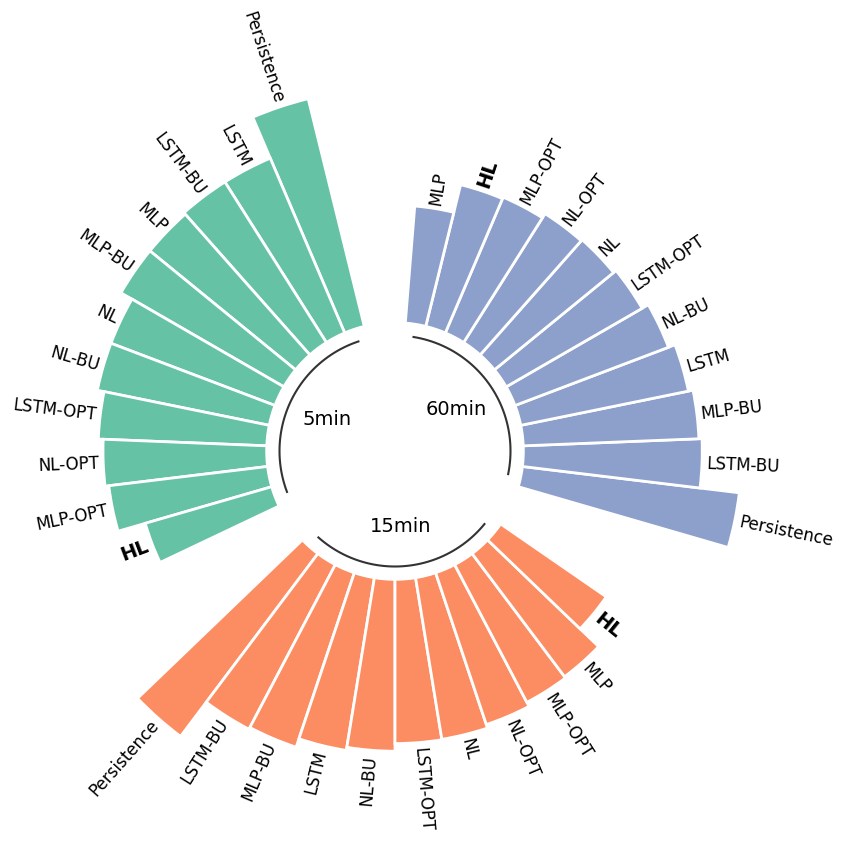

In [22]:
df_sorted = (
    df
    .groupby(["avg_terms"])
    .apply(lambda x: x.sort_values(["value"], ascending = False))
    .reset_index(drop=True)
)
VALUES = df_sorted["value"].values 
LABELS = df_sorted["methods"].values
GROUP = df_sorted["avg_terms"].values

PAD = 2
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))

start = 0
ANGLES = np.linspace(start, 2 * np.pi+start, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

GROUPS_SIZE = [len(i[1]) for i in df.groupby("avg_terms")]

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD
print(IDXS)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "polar"})

ax.set_theta_offset(OFFSET)
ax.set_ylim(-0.3,0.6)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [len(i[1]) for i in df.groupby("avg_terms")]
COLORS = [plt.get_cmap("Set2").colors[i] for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

# Add bars to represent ...
OFFSET = np.pi/2
ax.set_theta_offset(OFFSET)
ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="white", linewidth=2
)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

offset = 0 
for group, size in zip(["5min", "15min", "60min"], GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-0.03] * 50, color="#333333")
    
    # Add text to indicate group
    ax.text(
        np.mean(x1), -0.125, group, fontsize=14, ha="center", va="center"
    )
    
    # # Add reference lines at 20, 40, 60, and 80
    # x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    # ax.plot(x2, [0.02] * 50, color="#bebebe", lw=0.8)
    # ax.plot(x2, [0.04] * 50, color="#bebebe", lw=0.8)
    # ax.plot(x2, [0.06] * 50, color="#bebebe", lw=0.8)
    # ax.plot(x2, [0.08] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD
# fig.savefig("savings/single_res_costs.pdf",bbox_inches="tight")

Single wind costs (bar chart)

20
                     da_mean  ipb_mean   rt_mean        da_std   ipb_std   
Persistence         1.324683  2.114057  2.352684  2.328306e-16  0.000000  \
MLP-BU              1.249566  1.679042  2.319403  7.684064e-03  0.023654   
MLP-OPT             1.247647  1.652899  2.286833  6.132504e-03  0.018734   
MLP                 1.241838  1.639286  2.283397  1.745247e-02  0.026651   
Neural Laplace      1.236814  1.637265  2.214336  2.300485e-02  0.050374   
Neural Laplace-OPT  1.228424  1.581263  2.206056  1.759665e-02  0.050079   
LSTM                1.270046  1.780377  2.204392  1.106200e-02  0.054863   
Neural Laplace-BU   1.226585  1.609323  2.191614  1.816248e-02  0.053915   
Proposed            1.241896  1.630007  2.162369  2.593350e-02  0.057585   
LSTM-BU             1.280820  1.682802  2.110553  6.877331e-03  0.012420   
LSTM-OPT            1.279509  1.681578  2.109712  6.443003e-03  0.012032   

                          rt_std  
Persistence         4.656613e-16  
MLP-BU        

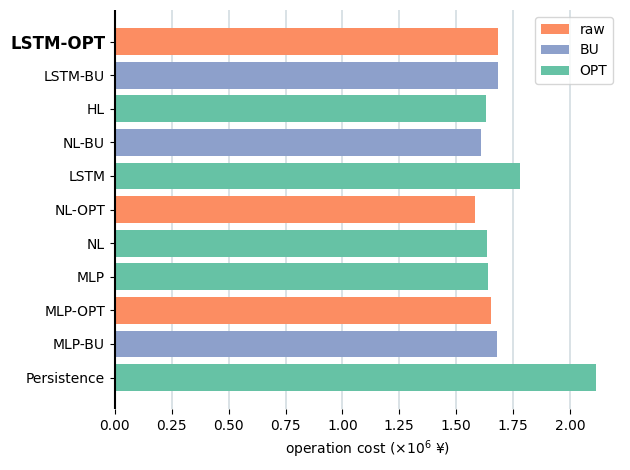

In [10]:
with open('savings/daid_strict_pn_fixed_load.pickle', 'rb') as handle:
# with open('savings/daid_pure_wind_strict_pn.pickle', 'rb') as handle:
    proposed_opt, names = pickle.load(handle)
print(len(proposed_opt))
# mean_opt = proposed_opt[5][0,...]
# std_opt = proposed_opt[5][0,...]
mean_opt = np.mean(proposed_opt, axis=0)[0,...]
std_opt = np.std(proposed_opt, axis=0)[0,...]
proposed_opt = pd.concat([pd.DataFrame(mean_opt, index=names,columns=["da_mean","ipb_mean","rt_mean"]), pd.DataFrame(std_opt, index=names,columns=["da_std","ipb_std","rt_std"])], axis=1)

proposed_opt = proposed_opt.sort_values(by='rt_mean', ascending=False) / 1e6
print(proposed_opt)
for c in proposed_opt.index.tolist():
    if c=="Neural Laplace":
        proposed_opt.rename(index={c:"NL"},inplace=True)
    if c=="Neural Laplace-BU":
        proposed_opt.rename(index={c:"NL-BU"},inplace=True)
    if c=="Neural Laplace-OPT":
        proposed_opt.rename(index={c:"NL-OPT"},inplace=True)
    if c=="Proposed":
        proposed_opt.rename(index={c:"HL"},inplace=True)

fig, ax = plt.subplots()
bars = []
for name in proposed_opt.index.tolist():
    if name.__contains__("OPT"):
        c = plt.get_cmap("Set2").colors[1]
    elif name.__contains__("BU"):
        c= plt.get_cmap("Set2").colors[2]
    else:
        c= plt.get_cmap("Set2").colors[0]
    b = ax.barh(name,
            proposed_opt.loc[name, "ipb_mean"],
            color=c)
    bars.append(b)
ax.legend([bars[-1],bars[-2],bars[-3]],["raw","BU","OPT"])
# ax.barh(proposed_opt.index.tolist(), proposed_opt["rt_mean"].values.flatten(), color=plt.get_cmap("Pastel1").colors[0])

# ax.set_xscale("log")
# ax.set_xticks([5.3,5.4,5.5,5.6,5.7])
# ax.set_xlim(1.2, 1.3)
# ax.set_xlim(5.2, 5.8)
ax.set_axisbelow(True)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2,visible=True, which="both",alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.set_xlabel("operation cost ($\\times 10^6$ ¥)")
for i, tick in enumerate(ax.get_yticklabels()):
    if i == 10:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.tight_layout()
# fig.savefig("savings/pure_wind.pdf", bbox_inches="tight")

Single load (bar chart)

20


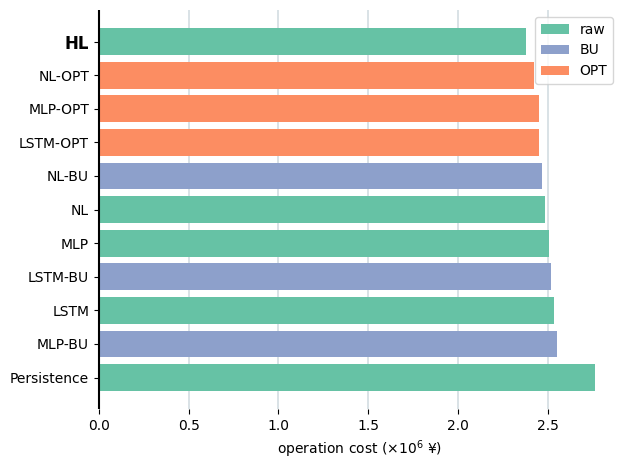

In [5]:
# with open('savings/daid_pure_load_strict_pn.pickle', 'rb') as handle:
with open('savings/daid_strict_pn_fixed_wind.pickle', 'rb') as handle:
    proposed_opt, names = pickle.load(handle)
print(len(proposed_opt))
mean_opt = np.mean(proposed_opt, axis=0)[:,0,...]
std_opt = np.std(proposed_opt, axis=0)[:,0,...]
proposed_opt = pd.concat([pd.DataFrame(mean_opt, index=names,columns=["da_mean","ipb_mean","rt_mean"]), pd.DataFrame(std_opt, index=names,columns=["da_std","ipb_std","rt_std"])], axis=1)

proposed_opt = proposed_opt.sort_values(by='rt_mean', ascending=False)/1e6
for c in proposed_opt.index.tolist():
    if c=="Neural Laplace":
        proposed_opt.rename(index={c:"NL"},inplace=True)
    if c=="Neural Laplace-BU":
        proposed_opt.rename(index={c:"NL-BU"},inplace=True)
    if c=="Neural Laplace-OPT":
        proposed_opt.rename(index={c:"NL-OPT"},inplace=True)
    if c=="Proposed":
        proposed_opt.rename(index={c:"HL"},inplace=True)

fig, ax = plt.subplots()
bars = []
for name in proposed_opt.index.tolist():
    if name.__contains__("OPT"):
        c = plt.get_cmap("Set2").colors[1]
    elif name.__contains__("BU"):
        c= plt.get_cmap("Set2").colors[2]
    else:
        c= plt.get_cmap("Set2").colors[0]
    b = ax.barh(name,
            proposed_opt.loc[name, "rt_mean"],
            color=c)
    bars.append(b)
ax.legend([bars[0],bars[1],bars[-2]],["raw","BU","OPT"])
# ax.barh(proposed_opt.index.tolist(), proposed_opt["rt_mean"].values.flatten(), color=plt.get_cmap("Pastel1").colors[0])

# ax.set_xscale("log")
ax.set_axisbelow(True)
# ax.set_xlim(4.2, 4.5)
ax.grid(axis = "x", color="#A8BAC4", lw=1.2,visible=True, which="both",alpha=0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_lw(1.5)
ax.spines["left"].set_capstyle("butt")
ax.set_xlabel("operation cost ($\\times 10^6$ ¥)")
for i, tick in enumerate(ax.get_yticklabels()):
    if i == 10:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.tight_layout()
# fig.savefig("savings/pure_load.pdf", bbox_inches="tight")



20


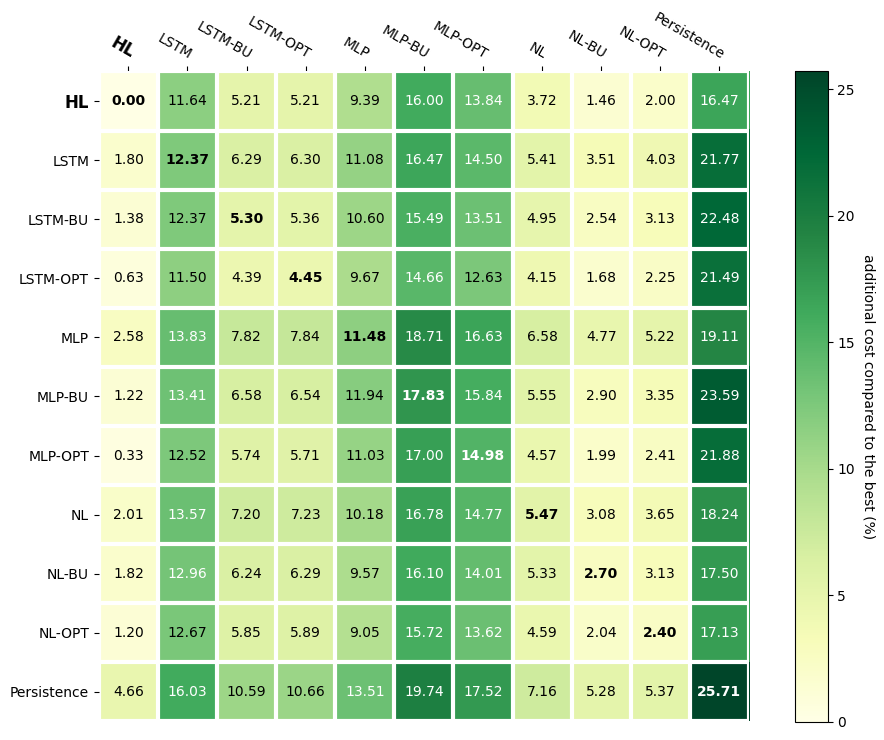

In [7]:
def heatmap(data,
            row_labels,
            col_labels,
            ax=None,
            cbar_kw=None,
            cbarlabel="",
            **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=-30,
             ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im,
                     data=None,
                     valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None,
                     **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if i!=j:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            else:
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw, weight="bold")

            texts.append(text)

    return texts


peneration_rate = 0.5
with open(f'savings/daid_all_strict_pn_{peneration_rate}.pickle', 'rb') as handle:
    proposed_opt, names = pickle.load(handle)


for i, c in enumerate(names):
    if c=="Neural Laplace":
        names[i] = "NL"
    if c=="Neural Laplace-BU":
        names[i] = "NL-BU"
    if c=="Neural Laplace-OPT":
        names[i] = "NL-OPT"
    if c=="Proposed":
        names[i] = "HL"
temp = names.pop()
names.insert(0, temp)
print(len(proposed_opt))
proposed_opt = np.mean(proposed_opt, axis=0)
# print(proposed_opt.shape)
proposed_opt = proposed_opt[:,:,-1]
# 5, 12
# proposed_opt = proposed_opt[6][..., -1]
proposed_opt = np.block([[proposed_opt[-1,-1],proposed_opt[-1,:-1].reshape(1,-1)],[proposed_opt[:-1,-1].reshape(-1,1),proposed_opt[:-1,:-1]]])

# print(proposed_opt)
# final_cost = (proposed_opt)/1e6
final_cost = (proposed_opt - proposed_opt.min())/proposed_opt.min() * 100
fig, ax = plt.subplots(figsize=[4*2.5, 3*2.5])
im, cbar = heatmap(final_cost,
                #    proposed_opt.index,
                #    proposed_opt.columns,
                names,names,
                   ax=ax,
                #    cmap="YlGnBu",
                   cmap="YlGn",
                   cbarlabel="additional cost compared to the best (%)")
texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=("black","white",))
# texts = annotate_heatmap(im, valfmt="{x:.2f}", textcolors=("white","black",))
for i, tick in enumerate(ax.get_yticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
for i, tick in enumerate(ax.get_xticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.tight_layout()
# fig.savefig(f"savings/loadwind_{peneration_rate}_all.pdf")

[{'LSTM': {1: [6393127.975330691, 9744724.54498673, 13868619.322301337, 11023225.073209116, 7910253.690445304, 23549878.727997087, 21426214.80288336, 9925541.888348376, 3840780.4708353467, 5598890.788429124, 9387174.76106641, 12406690.93751593, 15010606.461827833, 6480604.600791019, 6981061.24758398, 6582086.38210949, 9643795.972478498, 10379863.852202293, 9779790.715469092, 12864524.984758757, 11735497.4747263, 13452495.52950827, 11509367.688248038, 11971652.093549917, 10074954.26900807, 4889051.164360868, 4907069.137765731, 5156565.634382759, 4272672.969763292, 7408262.772643889, 4284832.063367564, 5151745.95174258, 7279617.403811289, 5255592.147642356, 6477323.990283787, 3836306.4749062434], 3: [2108994.6991285435, 3606900.3019828973, 3777104.812724076, 4889684.360681314, 3179077.894169309, 8024021.69493137, 3155635.623507566, 2567098.889045137, 1363192.4094418255, 2350837.096878896, 2257836.967393751, 3954731.933811266, 3511649.3062895574, 3674419.3701951844, 2367549.7786450367, 27

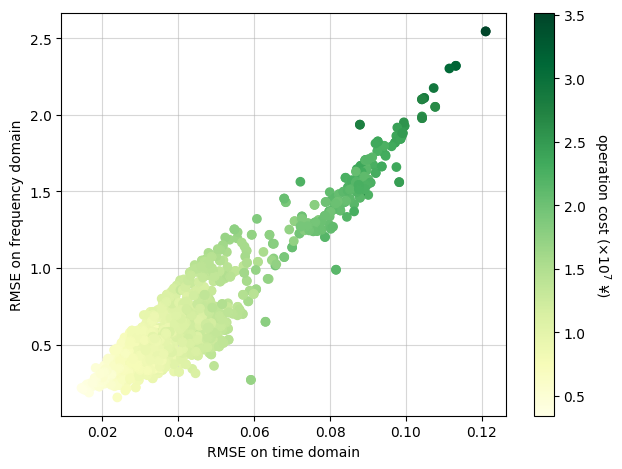

In [9]:
with open(f'savings/large_ramp_opt_20_{dataset}.pickle', 'rb') as handle:
# with open(f'savings/new_mix_mkt_opt_20_nrel.pickle', 'rb') as handle:
    proposed_opt = pickle.load(handle)
    print(proposed_opt)

all_opt_result = []
model_color = {name: i for i, name in enumerate(all_time_results.index)}
xs, ys, zs = [], [], []
fig, axs = plt.subplots()
for seed in range(20):
    seed_opt = proposed_opt[seed]

    opt_result = {name: {} for name in seed_opt.keys()}
    for name in seed_opt.keys():
        if name.__contains__("Persistence"):
            continue
        res_opt = seed_opt[name]
        sample_opt = np.array(res_opt[1][:7])
        x = detail_time_results[seed][name][1]
        y = detail_freq_results[seed][name][1]
        z = sample_opt
        xs.append(x)
        ys.append(y)
        zs.append(z)
# zs = np.array(zs).flatten()
# zs = (zs - zs.min()) / (zs.max() - zs.min()) * (8 - 3) + 3
axs.set_axisbelow(True)
axs.grid(alpha=0.5)
axs.set_xlabel("RMSE on time domain")
axs.set_ylabel("RMSE on frequency domain")
xs = np.array(xs).flatten()
ys = np.array(ys).flatten()
zs = np.array(zs).flatten()
p = axs.scatter(xs, ys, c=zs/1e7,cmap="YlGn")
# p = axs.scatter(xs, zs)
# p = axs.scatter(ys, zs)
cbar = axs.figure.colorbar(p, ax=axs)
cbar.ax.set_ylabel("operation cost ($\\times 10^7$ ¥)", rotation=-90, va="bottom")
fig.tight_layout()
# fig.savefig("savings/relationship.pdf")

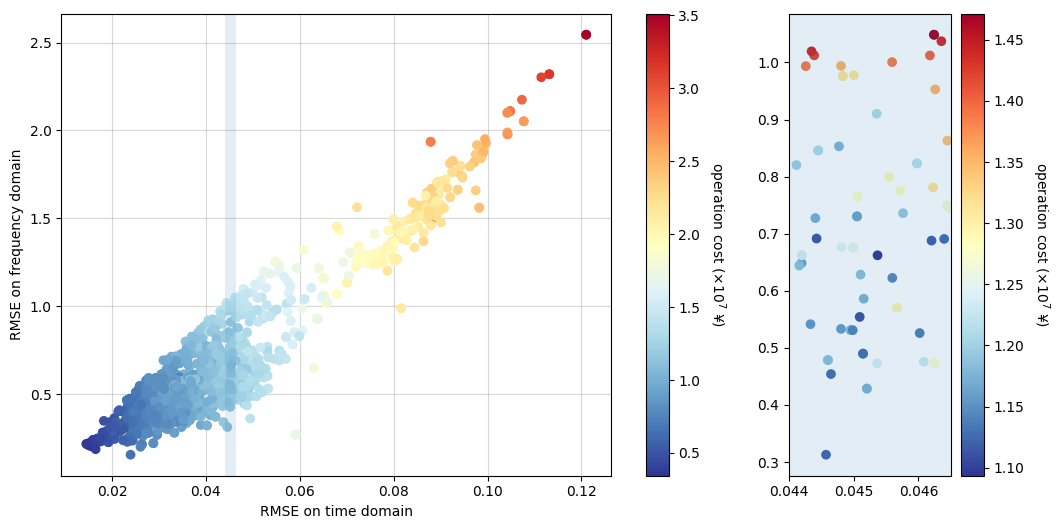

In [138]:
import matplotlib.pyplot as plt

from matplotlib.transforms import (Bbox, TransformedBbox,
                                   blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector,
                                                   BboxConnectorPatch,
                                                   BboxPatch)


def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False, ec="none")
    # p = BboxConnectorPatch(bbox1, bbox2,
    #                        loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
    #                        clip_on=False,
    #                        **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect01(ax1, ax2, xmin, xmax,ymin, ymax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    bbox = Bbox.from_extents(xmin, ymin, xmax, ymax)

    mybbox1 = TransformedBbox(bbox, ax1.get_xaxis_transform())
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=4, loc1b=2, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes

    Similar to zoom_effect01.  The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    # prop_patches = {"ec": "none", "alpha": 0.1}
    prop_patches = {**kwargs, "ec": "none"}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=4, loc1b=2, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    # ax2.add_patch(c1)
    # ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

axs = plt.figure(figsize=[12,6]).subplot_mosaic([
    ["main","main","main","zoom1"]
    # [""],
])

p = axs["main"].scatter(xs, ys, c=zs/1e7,cmap="RdYlBu_r")
# p = axs["main"].scatter(xs, ys, c=zs/1e7,cmap="YlGn")
# p = axs.scatter(xs, zs)
# p = axs.scatter(ys, zs)
axs["main"].set_axisbelow(True)
axs["main"].grid(alpha=0.5)
cbar = axs["main"].figure.colorbar(p, ax=axs["main"])
cbar.ax.set_ylabel("operation cost ($\\times 10^7$ ¥)", rotation=-90, va="bottom")

df = pd.DataFrame(np.stack([xs, ys, zs], axis=1), columns=["time","freq","cost"])
df = df[df["time"].between(0.044,0.0465)]
axs["zoom1"].set(xlim=(0.044, 0.0465))
# axs["zoom1"].set_xticks([])
# axs["zoom1"].set_yticks([])
p = axs["zoom1"].scatter(df["time"], df["freq"], c=df["cost"]/1e7,cmap="RdYlBu_r")
cbar = axs["zoom1"].figure.colorbar(p, ax=axs["zoom1"])
cbar.ax.set_ylabel("operation cost ($\\times 10^7$ ¥)", rotation=-90, va="bottom")
zoom_effect02(axs["zoom1"], axs["main"],alpha=0.125)
axs["main"].set_xlabel("RMSE on time domain")
axs["main"].set_ylabel("RMSE on frequency domain")

fig.tight_layout()
plt.savefig("savings/relationship_zoom_new.pdf",bbox_inches="tight")
plt.show()


freq parallel plot

           LSTM    LSTM-BU   LSTM-OPT        MLP     MLP-BU    MLP-OPT   
load  17.535482  17.535482  13.382585  10.398039  10.398039   2.198672  \
wind  15.703796  15.703796  15.783778  21.114688  21.114688  18.143024   

             NL      NL-BU    NL-OPT   HL  
load  11.323778  11.323778  8.854551  0.0  
wind   8.106407   8.106407  5.896541  0.0  
     methods   HL    NL-OPT         NL    MLP-OPT        MLP   LSTM-OPT   
load    load  0.0  8.854551  11.323778   2.198672  10.398039  13.382585  \
wind    wind  0.0  5.896541   8.106407  18.143024  21.114688  15.783778   

           LSTM  
load  17.535482  
wind  15.703796  


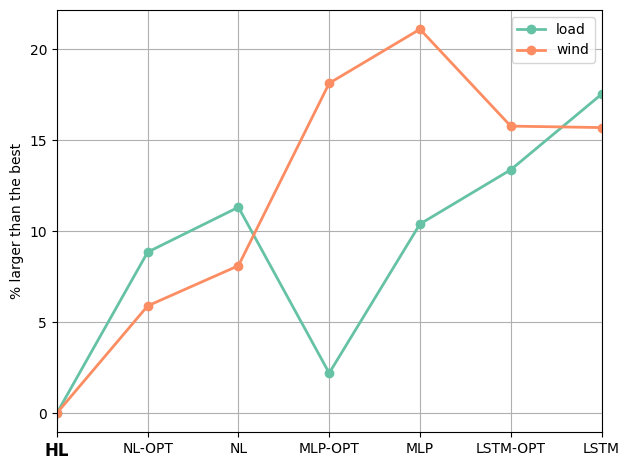

In [97]:
load_freq_df = pd.read_csv(f"savings/freq_rmse_mfred.csv", index_col=0, header=[0,1])[("mean", "1")]
wind_freq_df = pd.read_csv(f"savings/freq_rmse_nrel.csv", index_col=0, header=[0,1])[("mean", "1")]
load_freq_df /= load_freq_df.min()
wind_freq_df /= wind_freq_df.min()
load_freq_df -= 1
wind_freq_df -= 1
df = pd.concat([load_freq_df, wind_freq_df], axis=1)["mean"]
df.columns = ["load","wind"]
from pandas.plotting import parallel_coordinates
df = df.T * 100
df = df.rename(columns={"Proposed":"HL", "Neural Laplace":"NL", "Neural Laplace-BU":"NL-BU","Neural Laplace-OPT":"NL-OPT"})
print(df)
# df = df.sort_values(by="wind", ascending=True, axis=1)
# print(df)
df["methods"] = df.index
# proposed_df = df.pop("HL")
# df = pd.concat([proposed_df, df], axis=1)
df = df.drop(columns=["LSTM-BU","MLP-BU","NL-BU"])
df = df.iloc[:,::-1]
print(df)
# df.columns = ["HL","LSTM","LSTM-OPT","MLP","MLP-OPT","NL","NL-OPT","methods"]

fig, ax = plt.subplots()
parallel_coordinates(df,"methods",color=plt.get_cmap("Set2").colors,marker="o",lw=2,ms=6,ax=ax,axvlines=False)
ax.legend(loc="best")
# ax.set_title("RMSE in frequency domain")
ax.set_ylabel("% larger than the best")
# plt.setp(ax.get_xticklabels(),
#              rotation=30,
#              ha="right",
#              rotation_mode="anchor")
for i, tick in enumerate(ax.get_xticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.tight_layout()
fig.savefig("savings/freq_rmse.pdf",bbox_inches="tight")


          LSTM   LSTM-BU  LSTM-OPT       MLP    MLP-BU   MLP-OPT   
load  0.175355  0.175355  0.133826  0.103980  0.103980  0.021987  \
wind  0.157038  0.157038  0.157838  0.211147  0.211147  0.181430   

      Neural Laplace  Neural Laplace-BU  Neural Laplace-OPT  Proposed methods  
load        0.113238           0.113238            0.088546       0.0    load  
wind        0.081064           0.081064            0.058965       0.0    wind  
       HL      LSTM  LSTM-OPT       MLP   MLP-OPT        NL    NL-OPT
load  0.0  0.175355  0.133826  0.103980  0.021987  0.113238  0.088546
wind  0.0  0.157038  0.157838  0.211147  0.181430  0.081064  0.058965


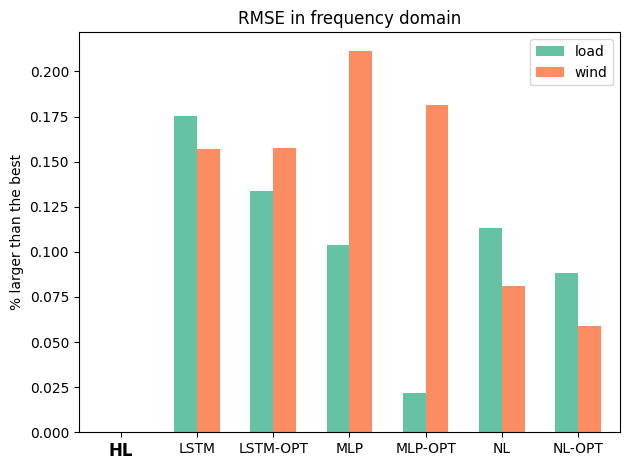

In [55]:
load_freq_df = pd.read_csv(f"savings/freq_rmse_mfred.csv", index_col=0, header=[0,1])[("mean", "1")]
wind_freq_df = pd.read_csv(f"savings/freq_rmse_nrel.csv", index_col=0, header=[0,1])[("mean", "1")]
load_freq_df /= load_freq_df.min()
wind_freq_df /= wind_freq_df.min()
load_freq_df -= 1
wind_freq_df -= 1
df = pd.concat([load_freq_df, wind_freq_df], axis=1)["mean"]
df.columns = ["load","wind"]
from pandas.plotting import parallel_coordinates
df = df.T * 1
df["methods"] = df.index
print(df)
proposed_df = df.pop("Proposed")
df = pd.concat([proposed_df, df], axis=1)
df = df.drop(columns=["LSTM-BU","MLP-BU","Neural Laplace-BU"])
df.columns = ["HL","LSTM","LSTM-OPT","MLP","MLP-OPT","NL","NL-OPT","methods"]
df.index = ["load","wind"]


fig, ax = plt.subplots()
df.drop(columns=["methods"],inplace=True)
print(df)
df.T.plot(kind='bar', ax=ax, color=plt.get_cmap("Set2").colors, width=0.6,rot=0)
ax.legend(loc="best")
ax.set_title("RMSE in frequency domain")
ax.set_ylabel("% larger than the best")
# plt.setp(ax.get_xticklabels(),
#              rotation=30,
#              ha="right",
#              rotation_mode="anchor")
for i, tick in enumerate(ax.get_xticklabels()):
    if i == 0:
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
fig.tight_layout()

In [132]:
# dataset = "solete"
# dataset = "mfred"
dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

all_freq_results, all_time_results = [], []
detail_time_results, detail_freq_results = [], []
# loop for seeds

# seed = np.random.permutation(20)[0]
# sample = 110

min_e = np.inf
for seed in range(20):
    for sample in range(435):

        # for i in range(len(proposed_preds)):
        proposed_model = {"Proposed": proposed_preds[seed]}
        all_preds = {
            **proposed_model,
            **bench_raw_preds[seed],
            **bench_bu_preds[seed],
            **bench_opt_preds[seed]
        }

        all_term_preds = all_preds["Proposed"]

        error = 0
        for j, avg_terms in enumerate(sorted(all_term_preds.keys())):
            preds, labels = all_term_preds[avg_terms][0:288//3]
            error += mean_squared_error(preds[sample].squeeze()[0:288//3], labels[sample].squeeze()[0:288//3])
        if error< min_e:
            min_e = error
            print(seed, sample)
            print(error)

0 0
18.85358738899231
0 50
18.052027225494385
0 51
17.863067388534546
0 62
15.439143002033234
0 77
12.880469799041748
0 78
11.160174369812012
0 79
5.316799163818359
0 109
4.675307214260101
0 222
4.416733384132385
0 225
3.9671231508255005
0 335
3.42476224899292
1 212
3.160331428050995
4 93
2.1664798855781555
6 354
1.4560126066207886
6 355
1.4260036945343018


4
93


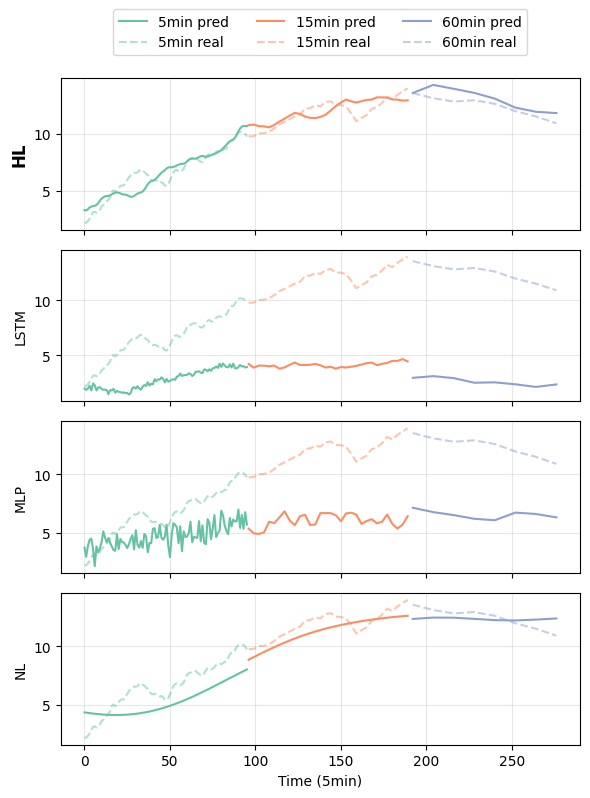

In [71]:
# dataset = "solete"
# dataset = "mfred"
dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

all_freq_results, all_time_results = [], []
detail_time_results, detail_freq_results = [], []
# loop for seeds

seed = 4
sample = 93

# seed = np.random.permutation(20)[0]
# sample = np.random.permutation(400)[0]
print(seed)
print(sample)
# for i in range(len(proposed_preds)):
proposed_model = {"Proposed": proposed_preds[seed]}
all_preds = {
    **proposed_model,
    **bench_raw_preds[seed],
    **bench_bu_preds[seed],
    **bench_opt_preds[seed]
}

names = ["Proposed", "LSTM", "MLP", "Neural Laplace"]
plt_names = {"Proposed":"HL", "LSTM":"LSTM", "MLP":"MLP", "Neural Laplace":"NL"}
fig, axs = plt.subplots(4, sharex=True, figsize=[6,8])
axs = axs.flatten()
for i, name in enumerate(names):
    all_term_preds = all_preds[name]
    start =0
    for j, avg_terms in enumerate(sorted(all_term_preds.keys())):
        end = start + 288 // 3
        preds, labels = all_term_preds[avg_terms]
        axs[i].plot(range(start, end, avg_terms), np.interp(range(start, end, avg_terms), range(avg_terms//2, 288, avg_terms), preds[sample].squeeze()), color=plt.get_cmap("Set2").colors[j], label=f"{avg_terms*5}min pred")
        axs[i].plot(range(start, end, avg_terms), np.interp(range(start, end, avg_terms), range(avg_terms//2, 288, avg_terms), labels[sample].squeeze()), color=plt.get_cmap("Set2").colors[j], ls="--", alpha=0.5,label=f"{avg_terms*5}min real")
        start = end 
        # axs[i].plot(range(288), np.interp(range(288), range(avg_terms//2, 288, avg_terms), preds[sample].squeeze()), color=plt.get_cmap("Set2").colors[j], label=f"{avg_terms*5}min pred")
        # if avg_terms == 1:

    # axs[i].plot(range(288), np.interp(range(288), range(avg_terms//2, 288, avg_terms), labels[sample].squeeze()), color="grey", label=f"{avg_terms*5}min pred",ls="--", alpha=0.5,)
    
    if name == "Proposed":
        axs[i].set_ylabel(plt_names[name], fontweight="bold", fontsize=12)
    else:
        axs[i].set_ylabel(plt_names[name])
    axs[i].set_axisbelow(True)
    axs[i].grid(alpha=0.3)
    # axs[i].plot(range(288), all_term_preds[1][1][sample].squeeze(), color="grey", label="real", ls="--", alpha=0.5)

axs[-1].set(xlabel="Time (5min)")

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# patch_5min = mpatches.Patch(color=plt.get_cmap("Set2").colors[0], label='5min')
# patch_15min = mpatches.Patch(color=plt.get_cmap("Set2").colors[1], label='15min')
# patch_60min = mpatches.Patch(color=plt.get_cmap("Set2").colors[2], label='60min')
# line_real = mlines.Line2D([], [], color='grey', label='real', ls="--")
# line_pred = mlines.Line2D([], [], color='grey', label='pred')

axs[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True,)


fig.tight_layout()
fig.savefig("savings/constent_seamless.pdf",bbox_inches="tight")

save to latex

In [22]:
latex_time = all_time_results
# latex_time = latex_time.swaplevel(1, 0, axis=1)*100
print(latex_time)
latex_time["mean"] = latex_time["mean"].round(3).astype(
    str) + " $\pm$ " + latex_time["std"].round(3).astype(str)
latex_time["mean"].to_csv(f"savings/{dataset}_time.csv")

                        mean       std      mean       std      mean       std
                          1         1         3         3         12        12
LSTM                5.188830  0.096850  5.307560  0.195860  5.403205  0.159790
LSTM-BU             5.188830  0.096850  5.176951  0.097438  5.118300  0.098254
LSTM-OPT            5.173866  0.085534  5.161971  0.085911  5.103324  0.086735
MLP                 5.149303  0.091195  4.927910  0.118691  4.680242  0.086694
MLP-BU              5.149303  0.091195  5.125773  0.090030  5.062638  0.090301
MLP-OPT             5.028260  0.074509  5.004119  0.073487  4.940931  0.074039
Neural Laplace      4.936882  0.380235  4.971793  0.267169  4.998867  0.349172
Neural Laplace-BU   4.936882  0.380235  4.929518  0.380654  4.868943  0.384021
Neural Laplace-OPT  4.812626  0.312117  4.805110  0.312493  4.743421  0.315572
Persistence         6.596242  0.000000  6.603842  0.000000  6.640212  0.000000
Proposed            4.641777  0.252007  4.616905  0.

In [18]:
latex_freq = all_freq_results
print(latex_freq)
latex_freq["mean"] = latex_freq["mean"].round(3).astype(
    str) + " $\pm$ " + latex_freq["std"].round(3).astype(str)
latex_freq["mean"].to_csv(f"savings/{dataset}_freq.csv")

                          mean       std       mean       std       mean   
                            1         1          3         3          12   
LSTM                 88.487045  2.709743  52.357910  2.964434  25.656652  \
LSTM-BU              88.487045  2.709743  50.680897  1.557941  24.407145   
LSTM-OPT             88.548213  2.411834  50.715900  1.386050  24.425500   
MLP                  92.625145  2.525963  49.842255  1.697672  22.837833   
MLP-BU               92.625145  2.525963  53.016426  1.443964  25.548670   
MLP-OPT              90.352498  2.025158  51.711929  1.156899  24.908473   
Neural Laplace       82.676773  7.025085  47.588020  3.152832  23.594305   
Neural Laplace-BU    82.676773  7.025085  47.351910  4.032035  22.791464   
Neural Laplace-OPT   80.986729  5.702946  46.381033  3.273864  22.314325   
Persistence         126.651688  0.000000  72.641380  0.000000  35.434715   
Proposed             76.477219  4.576384  43.546440  2.509539  20.830639   

           

Plot for showing

RMSE on different step $t$
$$RMSE(t)= \frac{1}{S}\sum_{s=1}^{S}\sqrt{\frac{1}{N}\sum_{i=1}^{N}\left(y_{s,i,t}-\hat{y}_{s,i,t}\right)}$$

$S$ = the number of seeds

$N$ = the number of samples

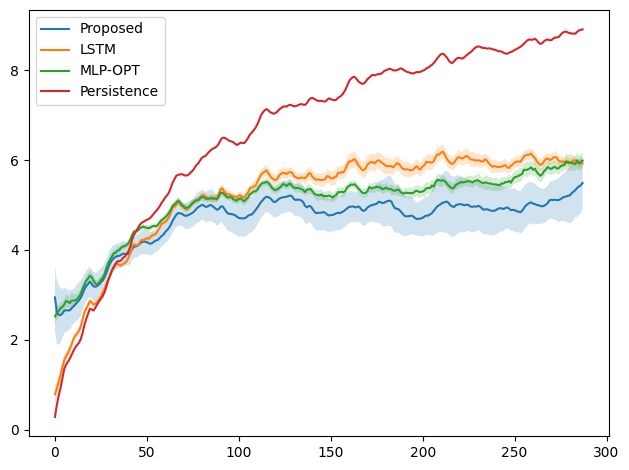

In [11]:
# dataset = "solete"
# dataset = "mfred"
dataset = "nrel"
avg_terms = 1

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)


all_freq_results, all_time_results = [], []
# loop for seeds
for i in range(20):
    # for i in range(len(proposed_preds)):
    proposed_model = {"Proposed": proposed_preds[i]}
    all_preds = {
        **proposed_model,
        **bench_raw_preds[i],
        **bench_bu_preds[i],
        **bench_opt_preds[i]
    }
    time_result = {name: [] for name in sorted(all_preds.keys())}

    # loop for models
    for name in sorted(all_preds.keys()):
        all_term_preds = all_preds[name]

        preds, labels = all_term_preds[avg_terms]

        preds = preds[2:][::4]
        labels = labels[2:][::4]
        error_freq = []

        time_result[name] = mean_squared_error(labels.squeeze(),
                                               preds.squeeze(),
                                               squared=False,
                                               multioutput="raw_values")

    df_time_result = pd.DataFrame(time_result)
    # print(df_time_result)
    all_time_results.append(df_time_result)

all_time_results = pd.concat(all_time_results, axis=0)
all_time_results = all_time_results.groupby(all_time_results.index).agg(
    ["mean", "std"])
# all_time_results
all_time_results = all_time_results.sort_index()
all_time_results = all_time_results.stack(level=1).transpose().swaplevel(
    1, 0, axis=1)
all_time_results
try:
    all_time_results = all_time_results.drop(
        ["Persistence-BU", "Persistence-OPT"], axis=0)
except:
    pass

fig, ax = plt.subplots()
# for name in all_time_results.index:
for name in ["Proposed", "LSTM", "MLP-BU", "MLP-OPT","Persistence"]:
    # if name.__contains__("OPT") or name.__contains__("BU") and not name.__contains__("Proposed"):
    #     continue
    if name.__contains__("BU") and avg_terms == 1:
        continue
    ax.plot(all_time_results.loc[name, "mean"], label=name)
    # print(all_time_results.loc[name, "mean"]-all_time_results.loc[name, "std"])
    ax.fill_between(
        range(len(all_time_results.loc[name, "mean"])),
        all_time_results.loc[name, "mean"] - all_time_results.loc[name, "std"],
        all_time_results.loc[name, "mean"] + all_time_results.loc[name, "std"], alpha=0.2)
# ax.set_xscale("log")

ax.legend()
# ax.set_xscale("log")
fig.tight_layout()

In [3]:
# with open(f'savings/mix_mkt_opt_20_nrel_schedule.pickle', 'rb') as handle:
with open(f'savings/daid_pure_wind.pickle', 'rb') as handle:
    proposed_opt = pickle.load(handle)

all_opt_result = []
# choose = 14
choose = np.random.permutation(19)[0]
print(choose)
seed = 0
# seed = np.random.permutation(20)[0]
print(seed)
seed_opt = proposed_opt[seed]
opt_result = {name: {} for name in seed_opt.keys()}
fig, ax = plt.subplots(figsize=[10,5])
fig2, ax2 = plt.subplots(figsize=[10,5])
fig3, ax3 = plt.subplots(figsize=[10,5])
# fig, ax = plt.subplots(len(seed_opt.keys()),
#                         len(seed_opt[list(seed_opt.keys())[0]].keys()),
#                         figsize=[10, 16])

for i, name in enumerate(seed_opt.keys()):
    # print(name)
    if (not name.__contains__("OPT")) and (not name.__contains__("Proposed")) or name.__contains__("Persistence"):
        continue
    # print(name)
    res_opt = seed_opt[name]
    # print(res_opt.keys())
    sample_opt = res_opt
    # sample_opt = res_opt[1]
    # print(sample_opt[choose][0].shape)
    # print(np.diff(sample_opt[choose][0].transpose().sum(axis=-1), axis=0).min())
    # print(np.diff(sample_opt[choose][0].transpose().sum(axis=-1), axis=0).max())

    ax3.plot(sample_opt[choose][0].transpose().sum(axis=-1), label=name)
    # ax2.plot((sample_opt[choose][5].transpose() / .9 + sample_opt[choose][4].transpose()*.9)*50/12, label=name)
    ax2.plot(sample_opt[choose][1].transpose() - sample_opt[choose][2].transpose(), label=name)
    ax.plot(sample_opt[choose][3].transpose(), label=name)

    # ax.plot((0, 288),(0,0),c="grey")

ax.legend()
fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

7
0


AttributeError: 'list' object has no attribute 'keys'

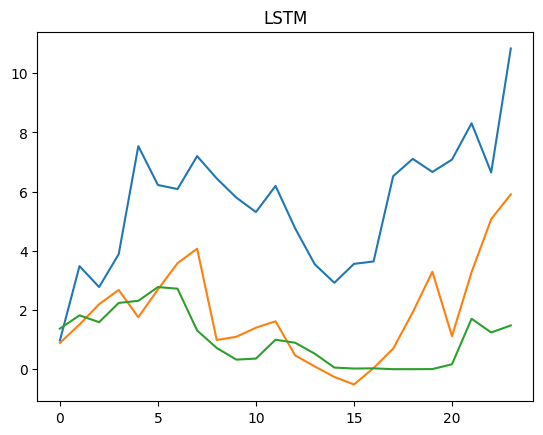

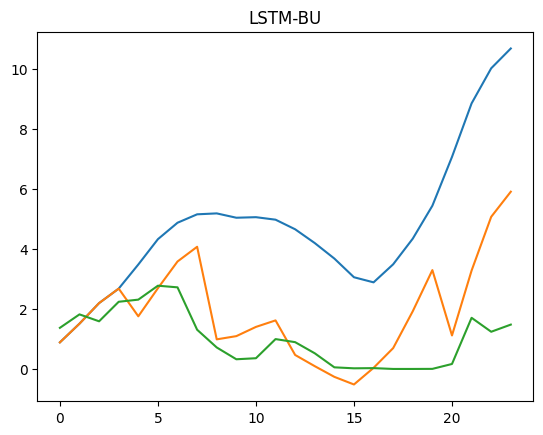

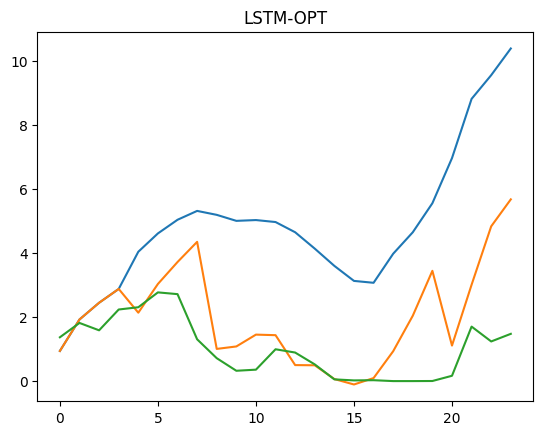

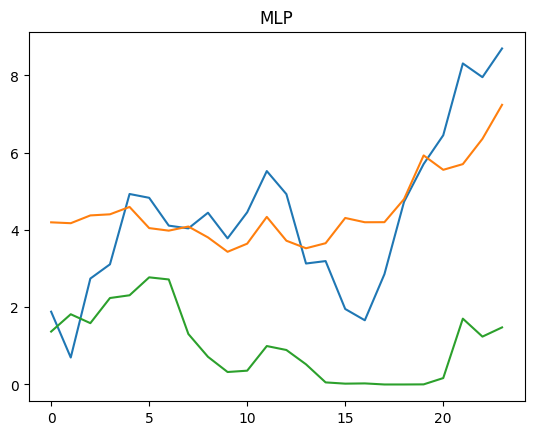

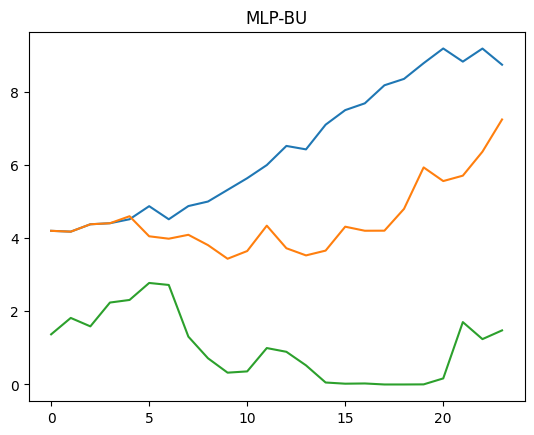

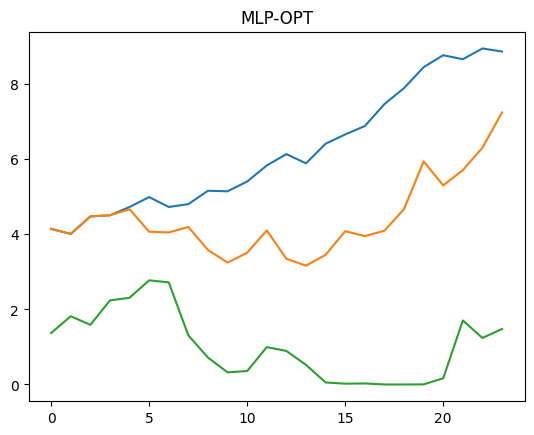

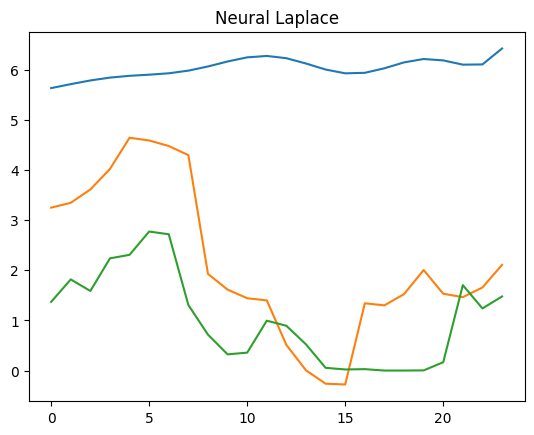

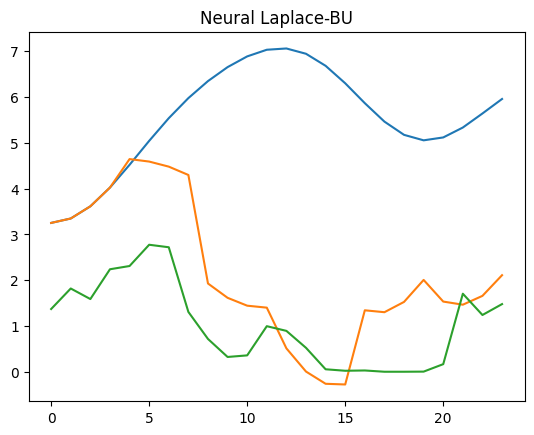

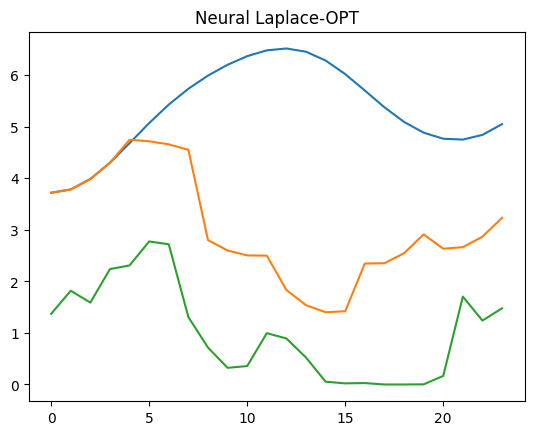

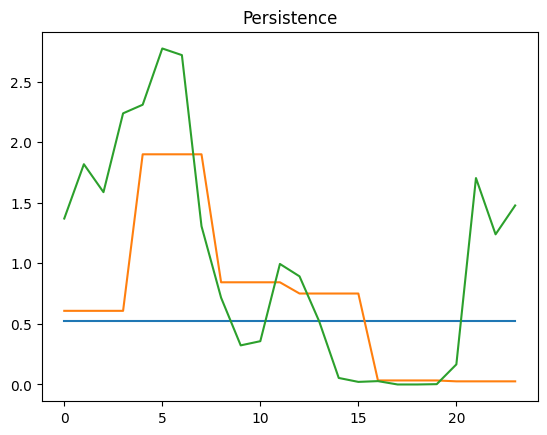

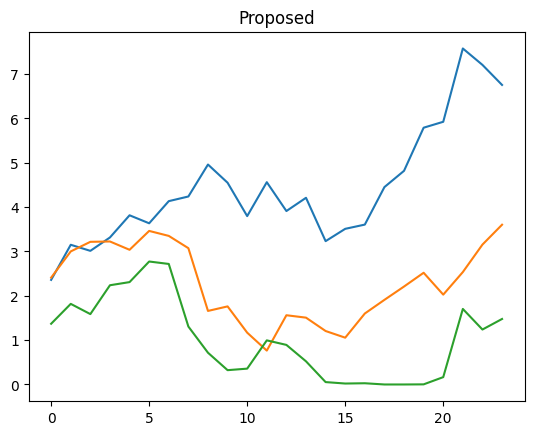

In [90]:
# dataset = "solete"
# dataset = "mfred"
dataset = "nrel"

with open(f'savings/proposed_20_{dataset}.pickle', 'rb') as handle:
    proposed_preds = pickle.load(handle)
with open(f'savings/bench_20_{dataset}.pickle', 'rb') as handle:
    bench_raw_preds = pickle.load(handle)
with open(f'savings/bench_bu_20_{dataset}.pickle', 'rb') as handle:
    bench_bu_preds = pickle.load(handle)
with open(f'savings/bench_opt_20_{dataset}.pickle', 'rb') as handle:
    bench_opt_preds = pickle.load(handle)

# all_freq_results, all_time_results = [], []
detail_time_results, detail_consistent_results = [], []
# loop for seeds
for i in range(20):
    # for i in range(len(proposed_preds)):
    proposed_model = {"Proposed": proposed_preds[i]}
    all_preds = {
        **proposed_model,
        **bench_raw_preds[i],
        **bench_bu_preds[i],
        **bench_opt_preds[i]
    }
    freq_result = {name: {} for name in sorted(all_preds.keys())}
    time_result = {name: {} for name in sorted(all_preds.keys())}
    d_freq_result = {name: {} for name in sorted(all_preds.keys())}
    d_time_result = {name: {} for name in sorted(all_preds.keys())}

    # loop for models
    for name in sorted(all_preds.keys()):
        if name.__contains__("Persistence-"):
            continue
        all_term_preds = all_preds[name]
        # loop for avg terms

        da_preds, da_labels = all_term_preds[12]
        ipb_preds, ipb_labels = all_term_preds[1]

        # # mfred
        # if dataset == "mfred":
        #     da_preds = da_preds[23:23 + 7 * 24][::24]
        #     da_labels = da_labels[23:23 + 7 * 24][::24]
        #     ipb_preds = ipb_preds[23:23 + 7 * 24]
        #     ipb_labels = ipb_labels[23:23 + 7 * 24]

        # nrel
        if dataset == "nrel":
            # preds = preds[2:][::24]
            # preds = np.where(preds<0,0,preds)
            # preds = np.where(preds>16,16,preds)
            # labels = labels[2:][::24]

            da_preds = da_preds[2:2 + 7 * 24][::24]
            da_labels = da_labels[2:2 + 7 * 24][::24]
            ipb_preds = ipb_preds[2:2 + 7 * 24]
            ipb_labels = ipb_labels[2:2 + 7 * 24]

        # loop for samples
        for n in range(len(da_preds)):
            day_preds = da_preds[n]
            # print(ipb_preds[0].squeeze().shape)
            rolling_preds = np.concatenate([
                ipb_preds[hour].squeeze()[:12 * 4]
                for hour in range(n, n + 24, 4)
            ])
            # print(rolling_preds.shape)
            avg_rolling_preds = np.split(rolling_preds, 24)
            # print(avg_rolling_preds.shape)
            avg_rolling_preds = np.stack([j.mean() for j in avg_rolling_preds],
                                         axis=0)
            fig, ax = plt.subplots()
            ax.plot(day_preds)
            ax.plot(avg_rolling_preds)
            ax.plot(da_labels[n])
            ax.set_title(name)
            detail_time_results.append(
                mean_squared_error(day_preds.squeeze(), da_labels[n].squeeze(), squared=False)
                + mean_squared_error(rolling_preds.squeeze(),
                                     ipb_labels[n].squeeze()))
            detail_consistent_results.append(
                mean_squared_error(day_preds.squeeze(),
                                   avg_rolling_preds.squeeze(), squared=False))
            break
        # break
    break

# fig, ax = plt.subplots()
# ax.scatter(detail_time_results, detail_consistent_results)
# ax.set_title(name)

<Axes: >

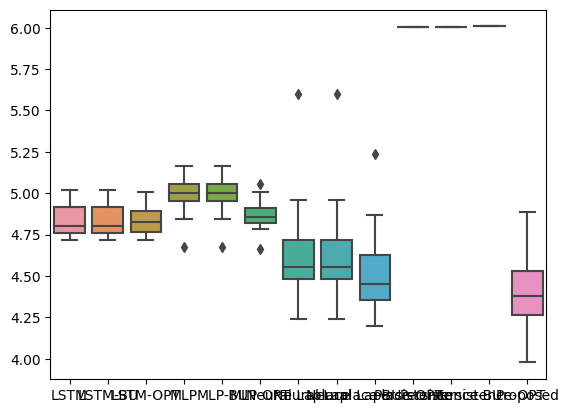

In [75]:
# all_time_results = all_time_results.stack()
# all_freq_results = all_freq_results.stack()
df = [pd.DataFrame(all_time_results.stack()[1][name].values, columns=[name]) for name in sorted(list(set(all_time_results.stack()[1].index.tolist())))]
# print(df)
df = pd.concat(df, axis=1)
df
# df = pd.DataFrame(all_time_results.stack()[1],columns=["value"])
# df
import seaborn as sns
# df
# df
sns.boxplot(df)
